# Introduction
This tutorial will introduce you to Latent Dirichlet allocation (LDA), one of the most commonly used methods in topic modeling. In natural language processing, topic model is used to infer topics from a collection of documents and automatically groups similar documents that share same topics together. In practice, the topic labels generated by topic models can be further used for text classification and contextual advertising. 

LDA is one common method in topic modeling. Given a corpus, LDA groups a collection of documents into several clusters and extracts topics for each cluster based on words in every document. Here, each document is treated as a mixture of different topics with different weights, and LDA assigns each document to a certain cluster based on the topic with the highest weight.

# Tutorial content
In this tutorial, we will show you how to perform some basic text analysis using LDA in Python, specifically using package lda. First, we will use a simple example to walkthrough the mechanism of LDA. Next, we will use the emails dataset in cross validation notebook to further explore the application of LDA in text analysis.


We will cover the following topics in this tutorial:

•	Installing the libraries

•	A Simple LDA walkthrough

•	Nature of LDA algorithm

•	Example application: emails dataset


# Installing the libraries
Before we get started, some libraries needed to be installed. You will install Lda using pip:

$ pip install lda

After installation, make sure the following commands work for you (you may need to use some packages we have used in text_processing.ipynb):

In [1]:
import numpy as np
import string
import nltk
import lda
import lda.datasets

# A simple LDA walkthrough
Now that we have installed and loaded the libraries, let's start our first example! We have prepared 5 documents in a corpus below:



In [2]:
doc_0="Wow! That sausage is amazing. I’ve had the little balls of sausage on pizza before, but getting the large, thick circular cuts are so much more authentic and you can even taste the meat better."
doc_1="Apply basic statistical techniques and analyses to understand properties of the data and to design experimental setups for testing hypotheses or collecting new data."
doc_2="The sauce and cheese were standard for any Sbarro pizza (still good), but the peppers add a nice balance to the pizza."
doc_3="Scale the methods to big data regimes, where distributed storage and computation are needed to fully realize capabilities of data analysis techniques."
doc_4="Italian Sausage and Peppers pizza is made with a sauce from Sicily (my favorite) and the crust has sprinkles of sesame seeds to give you that authentic flavor and feeling."
raw_corpus=[doc_0,doc_1,doc_2,doc_3,doc_4]

To better understand the LDA, the 5 documents are not picked randomly. In fact, doc_0,doc_2 and doc_4 are picked from a food review blog, while the other two documents are picked from our course website. You will see an interesting topic distribution given by the LDA model later.

As discussed before, the goal of implementing LDA model is to extract some topics from this set of corpus and represents each document using these topics.

# Step 1: processing the data
Similar to what we have done in text classification, we processes and tokenizes data into a format ready for feeding LDA model.

Specifications:

1.The tokens are in lower case

2.Remove punctuations

3.Only keep words that are made of letters(a-z)

4.Skip words in Stopwords list



In [3]:
def process(corpus, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Prepare data ready for lda model
    Inputs:
        corpus: list: list of documents, each document is a text string
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        tokenized_text: list of lists of tokenized text
    """
    tokenized_text=[]
    stopwords=nltk.corpus.stopwords.words('english')+[" "]
    
    for text in corpus:        
        text=text.lower()
        text=text.replace("'s","")
        text=text.replace("'","")
        text=text.replace("-"," ")
        text1=[word if word.isalpha() else " " for word in text.split(" ")]
      
        temp=[]
        for i in text1:
            try:
                word=lemmatizer.lemmatize(i)
                if(word not in stopwords):
                    temp.append(word)
            except UnicodeDecodeError as e:
                continue
        tokenized_text.append(temp)
    
    return tokenized_text
    pass

In [4]:
l=nltk.stem.wordnet.WordNetLemmatizer()
tokenized_text=process(raw_corpus,l)
print tokenized_text

[['sausage', 'little', u'ball', 'sausage', 'pizza', 'getting', 'thick', 'circular', u'cut', 'much', 'authentic', 'even', 'taste', 'meat'], ['apply', 'basic', 'statistical', u'technique', u'analysis', 'understand', u'property', 'data', 'design', 'experimental', u'setup', 'testing', u'hypothesis', 'collecting', 'new'], ['sauce', 'cheese', 'standard', 'sbarro', 'pizza', u'pepper', 'add', 'nice', 'balance'], ['scale', u'method', 'big', 'data', 'distributed', 'storage', 'computation', 'needed', 'fully', 'realize', u'capability', 'data', 'analysis'], ['italian', 'sausage', u'pepper', 'pizza', 'made', 'sauce', 'sicily', 'crust', u'ha', u'sprinkle', 'sesame', u'seed', 'give', 'authentic', 'flavor']]


# Step 2: Constructing document-term matrix
After we have processed and tokenized the raw corpus, let's construct a document-term matrix that can be used for LDA model directly.(Since we will be using lda library, the input format for lda.LDA should be a document-term matrix.)

Specifications:

1. The document-term matrix X is a m*n matrix where m is the number of documents in this corpus, and n is the unique words in corpus.

2. X_i,j denotes the number of times word j appears in ith document.


In [5]:
import collections 
import scipy.sparse as sp
def document_term_matrix(tokenized_text):
    """
    Create document-term matrix.

    Args:
        tokenized_text: list of lists of strings, where each string represents a tokenized document
    
    Returns: tuple: (tfidf, all_words)
        dt_matrix: (array-like)
        unique_words: list of strings, where the ith element indicates the word
                   that corresponds to the ith column in the document-term matrix
    """
    c=collections.Counter()
    dt_matrix=[]
    counter_list=[]
    for doc in tokenized_text:
        temp_counter=collections.Counter(doc)
        counter_list.append(temp_counter)
        c+=temp_counter         
    all_words=list(c)
    dict_words={}
    
    for i in range(0,len(counter_list)):
        current_list=[]
        for j in all_words:
            current_list.append(counter_list[i][j])
        dt_matrix.append(current_list)
    return (np.array(dt_matrix),all_words)
    pass


In [6]:
X,unique_words=document_term_matrix(tokenized_text)
print X
print unique_words

[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 2 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0
  1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0
  0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 1 0 0 0 0 0 0 1 0 0 0 1
  0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1]]
['collecting', 'cheese', 'computation', 'give', 'taste', 'storage', 'testing', 'crust', u'sprinkle', u'seed', 'design', 'statistical', 'sicily', 'apply', 'thick', 'made', 'flavor', 'even', 'sesame', 'sausage', u'cut', 'nice', 'data', u'technique', 'distributed', 'needed', 'add', 'much', 'sbarro', 'basic', 'new', 'sauce', u'method', 'circular', u'pepper', u'ball', 'big', 'little', 'standard', 'scale', u'hypothes

# Step 3: LDA modeling using lda library
Now we have the docuement_term matrix. Let's implement lda.LDA now. Recall we have picked the documents from two sources, the ideal number of topics in this case should be 2.

Specifications:

1. For initiating a LDA instance, we set number of topics to be 2, number of iterations to be 500 and random state gives a genertor for initial topics.

2. Fit the document-term matrix we just created to the model.

3. Get two outputs from the model: "topic_word" and "doc_topic". We will get a basic understanding of how LDA model works by looking at these ouputs.


In [7]:
model = lda.LDA(n_topics=2, n_iter=500, random_state=1)
model.fit(X)
topic_word = model.topic_word_ 
doc_topic = model.doc_topic_

In [8]:
print doc_topic
print doc_topic.shape

[[ 0.99295775  0.00704225]
 [ 0.00657895  0.99342105]
 [ 0.98913043  0.01086957]
 [ 0.08333333  0.91666667]
 [ 0.99342105  0.00657895]]
(5, 2)


In [9]:
print topic_word
print topic_word.shape

[[ 0.00025278  0.02553084  0.00025278  0.02553084  0.02553084  0.00025278
   0.00025278  0.02553084  0.02553084  0.02553084  0.00025278  0.00025278
   0.02553084  0.00025278  0.02553084  0.02553084  0.02553084  0.02553084
   0.02553084  0.07608696  0.02553084  0.02553084  0.00025278  0.00025278
   0.00025278  0.00025278  0.02553084  0.02553084  0.02553084  0.00025278
   0.00025278  0.0508089   0.00025278  0.02553084  0.0508089   0.02553084
   0.00025278  0.02553084  0.02553084  0.00025278  0.00025278  0.02553084
   0.0508089   0.00025278  0.02553084  0.02553084  0.02553084  0.00025278
   0.00025278  0.00025278  0.02553084  0.07608696  0.00025278  0.00025278
   0.00025278  0.02553084]
 [ 0.03664731  0.00036284  0.03664731  0.00036284  0.00036284  0.03664731
   0.03664731  0.00036284  0.00036284  0.00036284  0.03664731  0.03664731
   0.00036284  0.03664731  0.00036284  0.00036284  0.00036284  0.00036284
   0.00036284  0.00036284  0.00036284  0.00036284  0.10921626  0.03664731
   0.036647

# Interpretation of output

Topic distribution and word distribution for each topic are the two most essential outputs in LDA model. Let's look at "doc_topic" first. The "doc_topic" array gives the probabality of documents containing each topic. The number of topics in this model is 2, thus for each document we have two probability representing two topics. For example, document0 has a probability of 0.88461538 containing topic 1 and 0.11538462 containing topic 2. The sum of all topic probabilities for one document is 1. We choose the topic with high probability to represent each document:

doc_0: Topic 1

doc_1: Topic 2

doc_2: Topic 1

doc_3: Topic 2

doc_4: Topic 1


Document 0,2 and 4 have a higher probability to contain Topic 1 and the other two documents are more likely to contain Topic 2. Recall how we picked these 5 documents, document 0,2 and 4 are from food review and the other two are from the course website. The clustering result of LDA model is consistent with how we picked the corpus.

After we have grouped the corpus into two clusters. You may be curious about what the two topics represent. Now, let's move on to "topic_word". In this example, We have 65 unique words in our corpus. The topic_word array gives distributions of two topics over each word. That's why the shape of "topic_word" is 2*65.  Each probability corresponds to each element in unique_words list. For example, in topic 1, the first word in unique_words list is "collecting", and the probability of "collecting" in topic 1 is P('collecting'|topic 1)=0.00021436, while in topic 2, P('collecting'|topic 2)=0.03093415. If we choose 3 words with highest probability to represent the each topic:

Topic 1: piazza sausage authentic

Topic 2: data analysis technique


In [10]:
# choose top three words to represent every topic
for i in topic_word:
    index=i.argsort()[-3:][::-1]
    words=[unique_words[a]for a in index ]
    print words
    

['pizza', 'sausage', u'pepper']
['data', u'analysis', 'collecting']


Combine the two outputs together, we have the following list:

doc_0: Topic 1 piazza sausage authentic

doc_1: Topic 2 data analysis technique

doc_2: Topic 1 piazza sausage authentic

doc_3: Topic 2 data analysis technique

doc_4: Topic 1 piazza sausage authentic

Now, let's try using matplotlib to visualiza the topic for each document. 


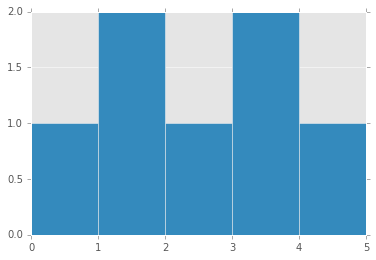

In [18]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
N, K = doc_topic.shape
ind = np.arange(N)
topics=np.argmax(doc_topic,axis=1)+1
width = 1
plt.bar(ind, topics, width=width)
plt.show()

# Step 4: Exploring the nature of LDA
First, let's talk about how a document is generated in LDA model. In LDA there are three layers: document, topic and words. Each document $i$ in a corpus has a topic distribution $\theta_i$, each topic $K$ has a word distribution $\phi_k$. The general process of generating a document is as follows:

1) Generate a topic distribution for document $i$, this distribution follows a Dirichlet distribution with prior parameter $\alpha$: $\theta_i$ ~ Dir($\alpha$)

2) From the topic distribution $\theta_i$ generate a topic for jth word in document $i$: $Z_i,j$ ~ Multinomial( $\theta_i$)

3) Generate a word distribution $\phi_k$ for topic in second step, this distribution follows a Dirichlet distribution with prior parameter $\beta$: $\phi_k$ ~ Dir($\beta$)

4) Each word $W_i,j$ in the word distribution $\phi_k$ follows a multinomial distribution: $W_i,j$ ~ Multinomial( $\phi_Zij$)

In the last walkthrough example, topic distribution $\theta_i$ is given in "doc_topic" and word distribution $\phi_k$ is given in "topic_word".

Hence, under Naive Bayes assumption, the total probability of this model is:

$$ P(W,Z,\theta,\phi ;\alpha,\beta) = \prod_{i=1}^{k}P(\phi_i;\beta) \prod_{j=1}^{M}P(\theta_j;\alpha) \prod_{t=1}^{N}P(Z_j,t|\theta_j)P(W_j,t|\phi_Zjt)$$

Assume we have M documents in one corpus, K topics in LDA model and total words of all documents is N.
When training LDA model, the goal is to maximize the total probability.

# Example application: tweets datasets

Now, we will explore the application of LDA model using emails dataset ("X1.txt" and "y1.txt")in cross_validation notebook. To get started, we will read emails from "X1.txt" and choose the first 2000 emails as out dataset. Then use process and document_term_matrix function to transform data into the right format ready for LDA model training. We set number of topics to be 2 for a start and will cover model evaluation in next section.


In [54]:
with open("X1.txt") as f:
    emails = f.readlines()
labels = np.loadtxt("y1.txt")
email=emails[:2000]
y=labels[:2000]

In [20]:
l=nltk.stem.wordnet.WordNetLemmatizer()
tokenized_email=process(email,l)

In [21]:
print type(tokenized_email)
X_email,unique_words_email=document_term_matrix(tokenized_email)
print len(unique_words_email)
print X_email.shape

<type 'list'>
15397
(2000, 15397)


In [43]:
model = lda.LDA(n_topics=2, n_iter=500, random_state=1)
model.fit(X_email)
print model.loglikelihood()

-1967305.78954


# Evaluation
Since LDA is an unsupervised learning algorithm, we can not compare the predicted labels with the true label to get a error data on testing data. However, we can evaluate the model parameter(eg. number of topics) based on loglikelihood. The higher the loglikelihood, the better the paremeters. 

We will train our LDA model using different number of topics from 1 to 9 and plot how loglikelihood changes as this parameter changes. When we increase the number of topics from 1 to 9, the loglikelihood increases dramatically in the beginning, however the loglikelihood doesn't increase much after the number of topics reaches 8. Therefore, n_topics=8 is the optimal paramter. 

In [42]:
results=[]
for i in range(1,10):
        model = lda.LDA(n_topics=i, n_iter=500, random_state=1)
        model.fit(X_email)
        results.append(model.loglikelihood())
print results

[-2079601.8354350799, -1967305.789538608, -1933548.9383407445, -1909601.7742064688, -1889431.416969519, -1883772.089928231, -1860279.5882902492, -1853363.814139061, -1854576.4501860759]


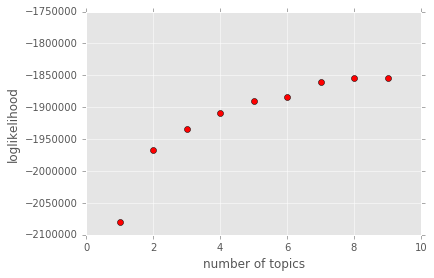

In [47]:
plt.plot(range(1,10), results, 'ro')
plt.ylabel('loglikelihood')
plt.xlabel('number of topics')
plt.axis([0, 10, -2100000, -1750000])
plt.show()

Let's look at the what topics the LDA model learned when set n_topics=8.
 

In [49]:
model = lda.LDA(n_topics=8, n_iter=500, random_state=1)
model.fit(X)
topics = model.topic_word_ 
for i in topics:
    index=i.argsort()[-8:][::-1]#change the number of top words if you want to view more in each topic
    words=[unique_words_email[a]for a in index ]
    print words

['suppressible', 'kuntz', 'chawil', 'jnuiq', 'crokscrew', 'hermann', 'multiplexor', 'originality']
['kwashiorkor', u'appropriation', 'murkalpert', 'collate', 'scold', 'buttonhole', 'prize', 'multiplexor']
['cdwr', 'perrino', 'jnuiq', 'childers', 'electricity', 'eligible', 'augustine', 'bringing']
['chloroplast', 'four', 'aegis', 'jnuiq', 'xtt', 'hermann', 'multiplexor', 'originality']
['avondale', 'swivel', 'xtt', 'druggingwaltham', 'disburden', 'hormone', 'specially', 'mli']
['mustachio', 'sturm', 'multiplexor', 'circuitry', 'deport', 'xtt', 'hermann', 'originality']
['originality', 'straight', 'strictest', 'internally', 'lord', 'tkxkyufnsmbk', u'trojan', 'crokscrew']
['chloroplast', 'electricity', 'xtk', 'regional', 'upartist', 'wabrrrfo', 'biometry', 'satchel']


Another way to improve the performance of LDA model is to reduce features of output. Here, we simply use the same techniques in find_frequent_indicator_words function. And see how the loglikelihood differs for two dataset given the same parameter n_topics.

In [63]:
import cPickle as pickle
def find_frequent_indicator_words(docs, y, threshold):   
    emails=np.array(docs)
    ham_word_counts=collections.Counter([])
    spam_word_counts=collections.Counter([])
    for a  in emails[y==1]:
        ham_word_counts =ham_word_counts+ collections.Counter(a)
    for a in emails[y==-1]:
        spam_word_counts  = spam_word_counts+collections.Counter(a)
    common=list(spam_word_counts&ham_word_counts)
    for i in common:
        del spam_word_counts[i]
        del ham_word_counts[i]

    spam=[k for  k in spam_word_counts if spam_word_counts[k]>=threshold]
    ham=[k for k in ham_word_counts if ham_word_counts[k]>=threshold]
    return (spam,ham)

    pass

s,h = find_frequent_indicator_words(tokenized_email, y, 30)
with open('student_data.pkl', 'wb') as f:
    pickle.dump((s,h), f)

with open('student_data.pkl', 'rb') as f:
        data = pickle.load(f)
spam=data[0]
ham=data[1]
# new matrix document_term
import collections
word_list=spam+ham
c=[collections.Counter(doc) for doc in tokenized_email]
document_term=np.array([[counter[word]for word in word_list] for counter in c])





In [56]:
results_new=[]
for i in range(1,10):
        model1 = lda.LDA(n_topics=i, n_iter=500, random_state=1)
        model1.fit(document_term)
        results_new.append(model1.loglikelihood())
print results_new

[-133204.20491057666, -122980.27860703712, -115704.24369550488, -110452.94969029722, -108849.42817557667, -106459.26490689052, -104290.29123100899, -103600.40420221051, -103672.39677060879]


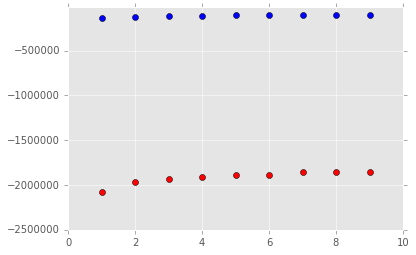

In [62]:
plt.plot(range(1,10), results, 'ro',range(1,10),results_new,'bo')
plt.axis([0, 10, -2500000, -10000])
plt.show()

# Summary and references
1.	Topic model: https://en.wikipedia.org/wiki/Topic_model
2.	Latent Dirichlet allocation: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
